In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")
from matplotlib.gridspec import GridSpec
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input
results_dir = "results/kato/2018-08-30/D{}".format(D)

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


# Dimensionality reduction on $\Delta$F/F 

In [4]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)

lim = 1.1 * abs(np.vstack(xs)).max()

In [5]:
# plt.figure(figsize=(12, 16))
# for w, (x, z) in enumerate(zip(xs, z_trues)):
#     for d in range(1, D):
#         ax = plt.subplot(D, W, (d-1) * W + w+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
#         plt.ylabel("PC {}".format(d+1) if w == 0 else "")
#         plt.title("worm {}".format(w+1))

# plt.suptitle("Continuous Latent States (Zimmer Labels)")
# plt.tight_layout()

In [8]:
# Load the best HMM
with open(os.path.join(results_dir, "best_hhmm_recurrent_robust_ar.pkl"), "rb") as f:
    hhmm, _ = pickle.load(f)

In [9]:
# Get the inferred states
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

# Make Figure 1: Real data, continuous states, discrete states

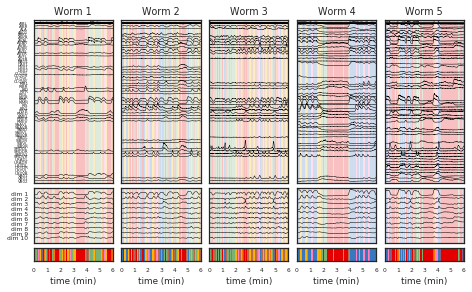

In [14]:
def make_figure_1(overlay=True, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, W, height_ratios=[12, 4, 1])

    for w in range(W):
        
        # Plot neural activity
        ax = fig.add_subplot(gs[0, w])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (ys[w][slc] - np.arange(N)) * ms[w][slc], '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names, fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        ax.set_title("Worm {}".format(w+1))

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, w])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -D, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (xs[w][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
            # ax.set_ylabel("Continuous States")
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = fig.add_subplot(gs[2, w])
        ax.imshow(z_infs[w][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

    figname = "figure1" if overlay else "figure1_white"
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

make_figure_1(overlay=True)
# make_figure_1(overlay=False)

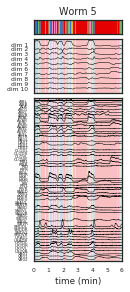

In [357]:
def make_figure_1_panel(w, overlay=True, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(1.75, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, 1, height_ratios=[1, 4, 12])

    # Plot discrete latent states
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(z_infs[w][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto")
    ax.set_xticks([])
    ax.set_yticks([])
    # if w == 0:
    #    ax.set_ylabel("Discrete States")
    ax.set_title("Worm {}".format(w+1))

    # Plot continuous latent states
    ax = fig.add_subplot(gs[1, 0])

    if overlay:
        ax.imshow(z_infs[w][slc][None, :], 
                  vmin=0, vmax=len(zplt.default_colors)-1, 
                  cmap=zplt.default_cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -D, 1), 
                  alpha=.25)

    ax.plot(tslc, (xs[w][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
    ax.set_yticks(np.arange(0, -D, -1))
    ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
    ax.set_ylim(-D,1)

    ax.set_xlim(tmin, tmax)
    ax.set_xticks([])

    # Plot neural activity
    ax = fig.add_subplot(gs[2, 0])

    if overlay:
        ax.imshow(z_infs[w][slc][None, :], 
                  vmin=0, vmax=len(zplt.default_colors)-1, 
                  cmap=zplt.default_cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -N, 1), 
                  alpha=.25)

    ax.plot(tslc, (ys[w][slc] - np.arange(N)) * ms[w][slc], '-k', lw=0.5)
    ax.set_yticks(-np.arange(N))
    ax.set_yticklabels(neuron_names, fontsize=4)
    ax.set_ylim(-N,1)

    ax.set_xlim(tmin, tmax)
    ax.set_xticks(np.arange(tmin, tmax+1))
    ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
    ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

    figname = "figure1_w{}".format(w) if overlay else "figure1_w{}_white".format(w)
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

make_figure_1_panel(4, overlay=True)
# make_figure_1_panel(4, overlay=False)

# Make Figure 2

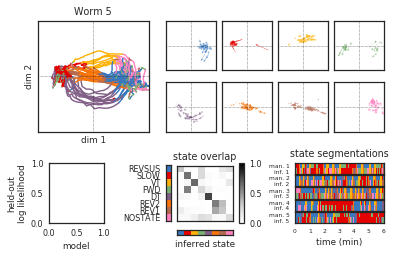

In [113]:
def make_figure_2(w=2, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.
    
    # Precompute stuff
    z = z_infs[w]
    x = xs[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))
    
    # Compute normalized overlap
    K_zimmer = 8
    overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
    for ww in range(W):
        for k1 in range(K_zimmer):
            for k2 in range(hhmm.K):
                overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

    # Normalize the overlap from all worms and plot
    overlap /= overlap.sum(1)[:, None]


    # Make plot
    fig = plt.figure(figsize=(6.5, 4.5))
    fig.patch.set_alpha(0)
    
    gs = GridSpec(int(4 / .1), int(6.5 / .1))

    # a. Plot the continuous latent states
    ax = fig.add_subplot(gs[:20,:20], aspect="equal")
    ax.patch.set_alpha(0)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, 0],
                x[cp_start:cp_stop + 1, 1],
                 '-', color=zplt.default_colors[z[cp_start]])        
    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(1))
    ax.set_xticks([])
    ax.set_ylim(-3, 3)
    ax.set_ylabel("dim {}".format(2))
    ax.set_yticks([])
    ax.set_title("Worm {}".format(w+1))
    
    # b. Plot the discrete dynamics
    qargs = dict(headwidth=7,
                 headlength=7,
                 alpha=0.75)

    for k in range(8):
        D = x.shape[1]
        ini = np.where(z == k)[0]
        if ini.size > 50:
            ini_inds = np.random.choice(ini.size, replace=False, size=50)
            ini = ini[ini_inds]

        Ak = hhmm.observations.As[w, k]
        bk = hhmm.observations.bs[w, k]
        dxdt = x.dot(Ak.T) + bk - x

        row, col = k // 4, k % 4
        ax = fig.add_subplot(gs[row * 10:row * 10 + 10, 22 + col * 10 + 1: 22+ col*10 + 10], aspect="equal")
        ax.patch.set_alpha(0)
        ax.quiver(x[ini, 0], x[ini, 1], dxdt[ini, 0], dxdt[ini, 1],
                  color=zplt.default_colors[k], **qargs)

        ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
        ax.plot([0, 0], [-3, 3], ':k', lw=0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
    
    # c. Plot the held-out likelihood 
    ax = fig.add_subplot(gs[24:34, 2:12])
    ax.set_ylabel("held-out\nlog likelihood")
    ax.set_xlabel("model")
    
    # d. Plot the state overlap    
    ax1 = fig.add_subplot(gs[24:34, 25:35])
    im = ax1.imshow(overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_title("state overlap")

    lax = fig.add_subplot(gs[24:34, 23])
    lax.imshow(np.arange(K_zimmer)[:, None], cmap=zplt.default_cmap, 
                  vmin=0, vmax=len(zplt.default_colors) - 1, aspect=1.5)
    
    lax.set_xticks([])
    lax.set_yticks(np.arange(K_zimmer))
    lax.set_yticklabels(z_true_key)

    bax = fig.add_subplot(gs[35, 25:35])
    bax.imshow(np.arange(hhmm.K)[None, :], cmap=zplt.default_cmap,  aspect="auto",
               vmin=0, vmax=len(zplt.default_colors)-1)
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")

    axcb = fig.add_subplot(gs[24:34, 36])
    plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])
    
    # e. Plot the manual and inferred state segmentations
    for ww in range(W):
        ax = fig.add_subplot(gs[24+ww*2:24+ww*2+2, 46:62])
        ax.imshow(np.row_stack((z_trues[ww][slc], z_infs[ww][slc])), 
                  cmap=zplt.default_cmap, 
                  vmin=0, vmax=len(zplt.default_colors) - 1, 
                  extent=(tmin, tmax, 0, 2),
                  aspect="auto")
        ax.set_xticks([])
        ax.set_yticks([1.5, .5])
        ax.set_yticklabels(["man. {}".format(ww+1), "inf. {}".format(ww+1)], fontsize=6)

        if ww == W-1:
            ax.set_xticks(np.arange(tmin, tmax+1))
            ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
            ax.set_xlabel("time (min)")
            
        if ww == 0:
            ax.set_title("state segmentations")
            
    
    figname = "figure2"
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

make_figure_2(w=4)


# Plot the continuous latent states 

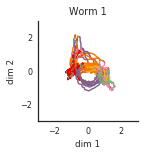

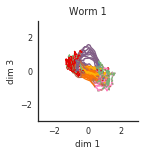

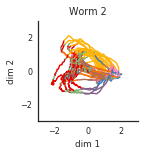

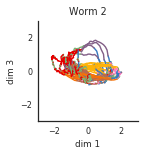

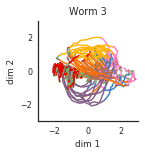

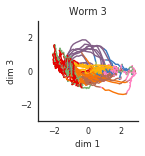

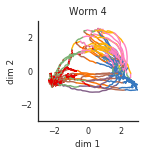

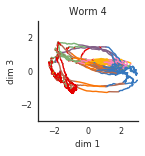

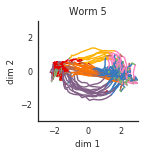

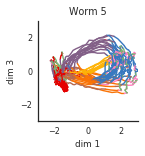

In [91]:
def make_figure_2(w=4, inds=(0, 1)):
    z = z_infs[w]
    x = xs[w]
    cps = np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

    # Make plot
    fig = plt.figure(figsize=(2, 2))
    fig.patch.set_alpha(0)
    ax = fig.add_subplot(111, aspect="equal")
    ax.patch.set_alpha(0)
    
    # Color denotes our inferred latent discrete state
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                x[cp_start:cp_stop + 1, inds[1]],
                 '-', color=zplt.default_colors[z[cp_start]])
        
    ax.set_xlim(-3, 3)
    ax.set_xlabel("dim {}".format(inds[0] + 1))
    ax.set_xticks([-2, 0, 2])
    
    ax.set_ylim(-3, 3)
    ax.set_ylabel("dim {}".format(inds[1] + 1))
    ax.set_yticks([-2, 0, 2])
    
    ax.set_title("Worm {}".format(w+1))
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    plt.tight_layout(pad=0.1)
    
    figname = "figure2_w{}_{}{}".format(w+1, inds[0], inds[1])
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

for w in range(W):
    make_figure_2(w=w, inds=(0, 1))
    make_figure_2(w=w, inds=(0, 2))

# Plot the dynamics as a vector field

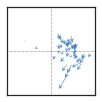

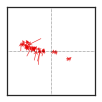

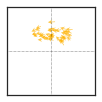

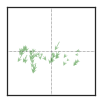

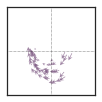

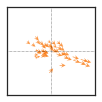

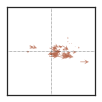

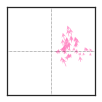

In [344]:
def make_figure_3(k, w, hhmm, N_plot=50, inds=(0, 1)):
    z = z_infs[w]
    x = xs[w]

    # qargs = dict(arrow_length_ratio=0.25,
    #              length=0.1,
    #              alpha=0.5)
    qargs = dict(headwidth=7,
                 headlength=7,
                 alpha=0.75)

    D = x.shape[1]
    ini = np.where(z == k)[0]

    # Look at the projected dynamics under each model
    # Subsample accordingly
    if ini.size > N_plot:
        ini_inds = np.random.choice(ini.size, replace=False, size=N_plot)
        ini = ini[ini_inds]

    Ak = hhmm.observations.As[w, k]
    bk = hhmm.observations.bs[w, k]
    dxdt = x.dot(Ak.T) + bk - x

    # Create figure
    fig = plt.figure(figsize=(1.25, 1.25))
    fig.patch.set_alpha(0)
    ax = fig.add_subplot(111, aspect="equal")
    ax.patch.set_alpha(0)

    ax.quiver(x[ini, inds[0]], x[ini, inds[1]],
              dxdt[ini, inds[0]], dxdt[ini, inds[1]],
              color=zplt.default_colors[k],
              **qargs)

    ax.plot([-3, 3], [0, 0], ':k', lw=0.5)
    ax.plot([0, 0], [-3, 3], ':k', lw=0.5)

#     ax.set_xlabel('dim {}'.format(inds[0]+1))
#     ax.set_ylabel('dim {}'.format(inds[1]+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    plt.tight_layout(pad=.1)
    
    figname = "figure3_w{}_k{}_{}{}".format(w+1, k+1, inds[0], inds[1])
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))
  
for k in range(hhmm.K):
    make_figure_3(k, 2, hhmm)

# Plot state overlap 

In [172]:
from matplotlib.cm import get_cmap
zimmer_colors = get_cmap("cubehelix")(np.linspace(0, 1, K_true))

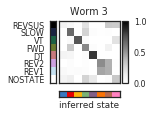

In [345]:
def make_figure_4(w):
    
    # Compute normalized overlap
    K_zimmer = 8
    overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
    for k1 in range(K_zimmer):
        for k2 in range(hhmm.K):
            overlap[k1, k2] += np.sum((z_trues[w] == k1) & (z_infs[w] == k2))

    # Normalize the overlap from all worms and plot
    overlap /= overlap.sum(1)[:, None]
    
    # Plot
    fig = plt.figure(figsize=(2, 1.5))
    fig.patch.set_alpha(0)
    
    gs = GridSpec(2, 3, height_ratios=[10, 1], width_ratios=[1, 10, 1])
    ax1 = fig.add_subplot(gs[0, 1])
    im = ax1.imshow(overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="auto")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Worm {}".format(w+1))

    lax = fig.add_subplot(gs[0, 0])
    lax.imshow(np.arange(K_zimmer)[:, None], 
               cmap="cubehelix",
               aspect="auto")
    lax.set_xticks([])
    lax.set_yticks(np.arange(K_zimmer))
    lax.set_yticklabels(z_true_key)

    bax = fig.add_subplot(gs[1, 1])
    bax.imshow(np.arange(hhmm.K)[None, :], 
               cmap=zplt.default_cmap, 
               vmin=0, vmax=len(zplt.default_colors)-1, 
               aspect="auto")
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("inferred state")

    axcb = fig.add_subplot(gs[0, 2])
    plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])
    
    plt.tight_layout(pad=.25)

    figname = "figure4_w{}".format(w+1)
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

make_figure_4(2)

windows blue : REVSUS
red : SLOW
amber : VT
faded green : FWD
dusty purple : DT
orange : REV2
clay : REV1
pink : NOSTATE


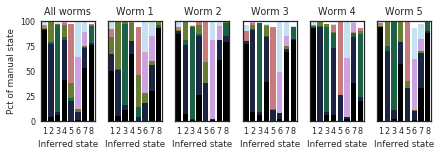

In [191]:
# Helper function to find overlap percentages
best_hhmm_K = hhmm.K
def compute_pct_overlap(zi, ztr):
    overlap = np.zeros((best_hhmm_K, K_true))
    for k in range(best_hhmm_K):
        overlap[k] = np.bincount(ztr[zi == k], minlength=K_true).astype(float)
        overlap[k] /= (overlap[k].sum() + 1e-3)
    return overlap

# Find a permutation so that the bar codes look progressive
total_overlap = compute_pct_overlap(np.concatenate(z_infs), np.concatenate(z_trues))
# overlap_perm = np.argsort(np.argmax(total_overlap, axis=1))
overlap_perm = np.arange(best_hhmm_K)

# Helper function to plot "barcodes"
def plot_overlap_barcode(ax, overlap):
    for i,k in enumerate(overlap_perm):        
        for ktr in range(K_true):
            plt.bar(i, overlap[k, ktr], bottom=np.sum(overlap[k, :ktr]), color=zimmer_colors[ktr], width=0.8)
    ax.set_xlim(-.5, best_hhmm_K-.5)
    
# Plot all overlaps as bar codes
plt.figure(figsize=(6, 2.))

# Plot the total overlap first
ax = plt.subplot(1, W+1, 1)
plot_overlap_barcode(ax, total_overlap)
plt.ylabel("Pct of manual state")
plt.yticks([0, .25, .5, .75, 1], [0, 25, 50, 75, 100])
plt.ylim(0, 1)
plt.xlabel("Inferred state")
plt.xticks(np.arange(best_hhmm_K), np.arange(best_hhmm_K)+1)
plt.title("All worms")

for w in range(W):
    ax = plt.subplot(1, W+1, w+2)
    overlap_w = compute_pct_overlap(z_infs[w], z_trues[w])
    plot_overlap_barcode(ax, overlap_w)
    plt.yticks([])        
    plt.ylim(0, 1)
    plt.xlabel("Inferred state")
    plt.xticks(np.arange(best_hhmm_K), np.arange(best_hhmm_K)+1)
    plt.title("Worm {}".format(w+1))
plt.tight_layout(pad=0.1)

# Print key
for color_name, state_name in zip(zplt.color_names, z_true_key):
    print("{} : {}".format(color_name, state_name))

# Plot true and inferred segmentations

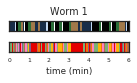

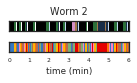

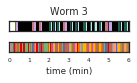

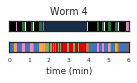

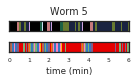

In [343]:
def make_figure_4b(w, tmin=0, tmax=6):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.


    fig = plt.figure(figsize=(2.0, 1.25))
    fig.patch.set_alpha(0)
    gs = GridSpec(2, 1)

    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(z_trues[w][slc][None, :], cmap="cubehelix", aspect="auto", extent=(tmin, tmax, 0, 1))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Worm {}".format(w+1))

    ax2 = fig.add_subplot(gs[1,0])
    ax2.imshow(z_infs[w][slc][None, :], 
               cmap=zplt.default_cmap, 
               vmin=0, vmax=len(zplt.default_colors) - 1, 
               extent=(tmin, tmax, 0, 1),
               aspect="auto")
    ax2.set_xticks([])
    ax2.set_xticks(np.arange(tmin, tmax+1))
    ax2.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
    ax2.set_xlabel("time (min)")
    ax2.set_yticks([])
    
    plt.tight_layout()
    
    figname = "figure4b_w{}".format(w+1)
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))
    
for w in range(W):
    make_figure_4b(w)

# Simulate from an HMM, reducing the dynamics noise

In [21]:
hhmm_low_noise = copy.deepcopy(hhmm)
hhmm_low_noise.observations.inv_sigmas -= 4

In [312]:
pad = 3

N_smpls = 20

zsmpls = []
xsmpls = []
ysmpls = []
wsmpls = []

for s in range(N_smpls):
    for w in range(W):
        print("Worm ", w, " sample ", s)
        # Sample data
        Tsmpl = Ts[w]
        zpre, xpre = z_infs[w][-pad:], xs[w][-pad:]
        zsmpl, xsmpl = hhmm_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=w, with_noise=True)

        zsmpl = np.concatenate((zpre, zsmpl))
        xsmpl = np.concatenate((xpre, xsmpl))

        # Truncate to stable region
        unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 5, axis=1)]
        T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
        zsmpl = zsmpl[:T_stable]
        xsmpl = xsmpl[:T_stable]

        # Project into neural space
        ysmpl = xsmpl.dot(pca.components_) + pca.mean_

        # Append
        zsmpls.append(zsmpl)
        xsmpls.append(xsmpl)
        ysmpls.append(ysmpl)
        wsmpls.append(w)

Worm  0  sample  0
Worm  1  sample  0
Worm  2  sample  0
Worm  3  sample  0
Worm  4  sample  0
Worm  0  sample  1
Worm  1  sample  1
Worm  2  sample  1
Worm  3  sample  1
Worm  4  sample  1
Worm  0  sample  2
Worm  1  sample  2
Worm  2  sample  2
Worm  3  sample  2
Worm  4  sample  2
Worm  0  sample  3
Worm  1  sample  3
Worm  2  sample  3
Worm  3  sample  3
Worm  4  sample  3
Worm  0  sample  4
Worm  1  sample  4
Worm  2  sample  4
Worm  3  sample  4
Worm  4  sample  4
Worm  0  sample  5
Worm  1  sample  5
Worm  2  sample  5
Worm  3  sample  5
Worm  4  sample  5
Worm  0  sample  6
Worm  1  sample  6
Worm  2  sample  6
Worm  3  sample  6
Worm  4  sample  6
Worm  0  sample  7
Worm  1  sample  7
Worm  2  sample  7
Worm  3  sample  7
Worm  4  sample  7
Worm  0  sample  8
Worm  1  sample  8
Worm  2  sample  8
Worm  3  sample  8
Worm  4  sample  8
Worm  0  sample  9
Worm  1  sample  9
Worm  2  sample  9
Worm  3  sample  9
Worm  4  sample  9
Worm  0  sample  10
Worm  1  sample  10
Worm  2  s

In [307]:
# for w, ysmpl in enumerate(ysmpls):
#     plt.figure(figsize=(12, 8))
#     plt.plot(np.arange(ysmpl.shape[0]) / 3.0, ysmpl - np.arange(N), '-k')
#     plt.yticks(-np.arange(N), neuron_names)
#     plt.ylim(-N,1)
#     plt.xlim(0, Ts[w] / 3.0)
#     plt.xlabel("time (s)")
#     plt.title("Simulated Worm {}".format(w + 1))
    
#     # Plot real data for comparison
#     plt.figure(figsize=(12, 8))
#     plt.plot(np.arange(Ts[w]) / 3.0, (ys[w] - np.arange(N)) * ms[w], '-', color=zplt.default_colors[3])
#     plt.yticks(-np.arange(N), neuron_names)
#     plt.ylim(-N,1)
#     plt.xlim(0, Ts[w] / 3.0)
#     plt.xlabel("time (s)")
#     plt.title("Real Worm {}".format(w + 1))
    
#     plt.pause(.1)

# Plot the true and simulated duration distributions

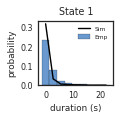

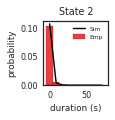

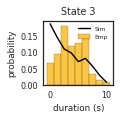

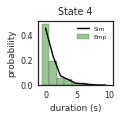

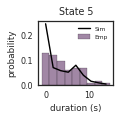

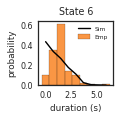

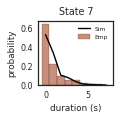

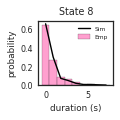

In [311]:
from pyhsmm.util.general import rle
from scipy.stats import geom

def make_figure_5(k, w):
    # Get the durations of inferred states
    states, durs = list(zip(*[rle(z) for z in z_infs]))
    states = np.concatenate(states)
    durs = np.concatenate(durs)
    valid = durs > 0
    states = states[valid]
    durs = durs[valid]

    # Get the durations of the real states
    dk = durs[states == k]
    dmax = dk.max()
    bins = np.linspace(0, dmax+1, 10)
    width = (bins[1] - bins[0]) 

    # Fit a geometric distribution
    g = geom(1 / np.mean(dk))

    # Create figure
    fig = plt.figure(figsize=(1.5, 1.5))
    fig.patch.set_alpha(0)
    ax = fig.add_subplot(111)
    ax.patch.set_alpha(0)

    # Plot the histogram of inferred transitions
    tmp, _ = np.histogram(dk / 3.0, bins / 3.0, density=True)
    plt.bar(bins[:-1] / 3.0, tmp, width=width / 3.0,
            color=zplt.default_colors[k], alpha=0.75, edgecolor='k', label="Emp")

    # Get simulated state durations
    sim_states, sim_durs = list(zip(*[rle(z) for z in zsmpls]))
    sim_states = np.concatenate(sim_states)
    sim_durs = np.concatenate(sim_durs)
    valid = sim_durs > 0
    sim_states = sim_states[valid]
    sim_durs = sim_durs[valid]
    sim_dk = sim_durs[sim_states == k]

    tmp, _ = np.histogram(sim_dk / 3.0, bins / 3.0, density=True)
    plt.plot(bins[:-1] / 3.0, tmp, '-k', label="Sim")

    # Plot the geometric distribution under Markov
#     bins = np.arange(1, dmax+1)
#     plt.plot(bins[:-1] / 3.0, g.pmf(bins[:-1]) * 3.0, ':k', label="Mkv")

    plt.xlabel("duration (s)")
    plt.ylabel("probability")
    plt.legend(loc="upper right", fontsize=6)
    plt.title("State {}".format(k+1))

    plt.tight_layout(pad=0.1)

    figname = "figure5_w{}_k{}".format(w+1, k+1)
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

for k in range(hhmm.K):
    make_figure_5(k, 4)

# Plot the transition probabilities as a function of state and location

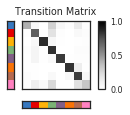

In [395]:
from scipy.misc import logsumexp
P = np.exp(hhmm.transitions.shared_log_Ps - logsumexp(hhmm.transitions.shared_log_Ps, axis=1, keepdims=True))

# Plot
fig = plt.figure(figsize=(1.5 * 12/11, 1.5))
fig.patch.set_alpha(0)

gs = GridSpec(2, 3, height_ratios=[10, 1], width_ratios=[1, 10, 1])
ax1 = fig.add_subplot(gs[0, 1])
im = ax1.imshow(P, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect=1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Transition Matrix")

lax = fig.add_subplot(gs[0, 0])
lax.imshow(np.arange(hhmm.K)[:, None], 
           cmap=zplt.default_cmap,
           vmin=0, vmax=len(zplt.default_colors)-1, 
           aspect=1/.8)
lax.set_xticks([])
lax.set_yticks([])

bax = fig.add_subplot(gs[1, 1])
bax.imshow(np.arange(hhmm.K)[None, :], 
           cmap=zplt.default_cmap, 
           vmin=0, vmax=len(zplt.default_colors)-1, 
           aspect=.8)
bax.set_xticks([])
bax.set_yticks([])

axcb = fig.add_subplot(gs[0, 2], aspect=10)
plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])

plt.tight_layout(pad=.1)

figname = "figure5_P"
plt.savefig(os.path.join(results_dir, figname + ".pdf"))
plt.savefig(os.path.join(results_dir, figname + ".png"))

/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


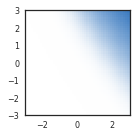

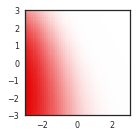

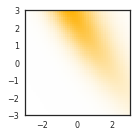

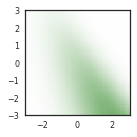

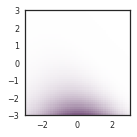

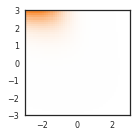

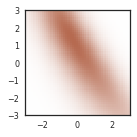

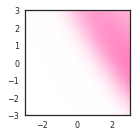

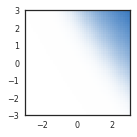

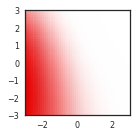

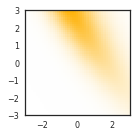

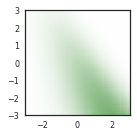

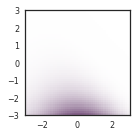

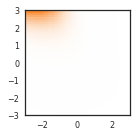

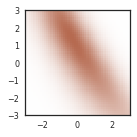

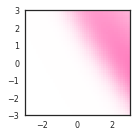

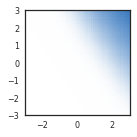

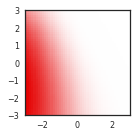

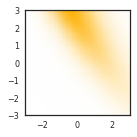

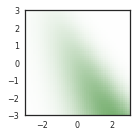

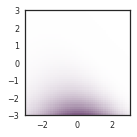

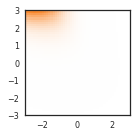

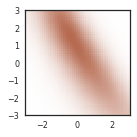

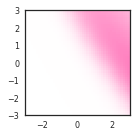

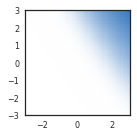

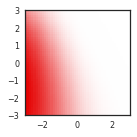

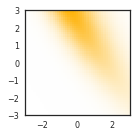

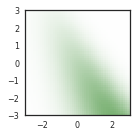

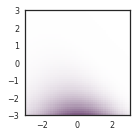

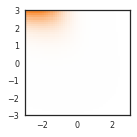

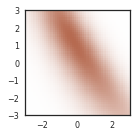

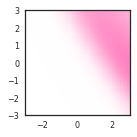

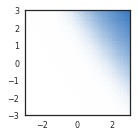

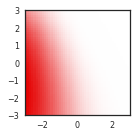

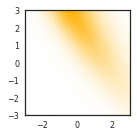

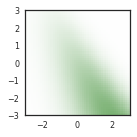

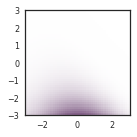

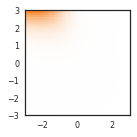

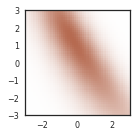

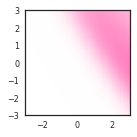

In [412]:
from hips.plotting.colormaps import gradient_cmap
from ssm.util import one_hot

def plot_trans_probs(k, w, xlim=(-3, 3), ylim=(-3, 3), inds=(0, 1), n_pts=50, ax=None):
    XX, YY = np.meshgrid(np.linspace(*xlim, n_pts),
                         np.linspace(*ylim, n_pts))
    XY = np.column_stack((np.ravel(XX), np.ravel(YY)))
    
    data = np.zeros((n_pts**2, D))
    data[:, inds[0]] = np.ravel(XX)
    data[:, inds[1]] = np.ravel(YY)

    # Estimate the bias
    p_stationary = np.mean(np.concatenate([one_hot(zi, hhmm.K) for zi in z_infs]), axis=0)
    r = p_stationary.dot(hhmm.transitions.log_Ps[w])
    
    R = hhmm.transitions.Rs[w]
    log_P = data.dot(R.T) + r
    test_prs = np.exp(log_P - logsumexp(log_P, axis=1, keepdims=True))
    
    # Get the transition probabilities for this pair of dimensions
#     # set the location along other dimensions to be zero
#     data = np.zeros((n_pts**2, D))
#     data[:, inds[0]] = np.ravel(XX)
#     data[:, inds[1]] = np.ravel(YY)
#     mask = np.ones((n_pts**2, D), dtype=bool)
#     inputs = np.zeros((n_pts**2, 0))
#     tag = w
    
#     log_Ps = hhmm.transitions.log_transition_matrices(data, inputs, mask, tag)
#     test_prs = np.exp(log_Ps)

    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(111)

    start = np.array([1., 1., 1., 0.])
    end = np.concatenate((zplt.default_colors[k], [1]))
    cmap = gradient_cmap([start, end])
    im1 = ax.imshow(test_prs[:, k].reshape(*XX.shape),
                    extent=xlim + tuple(reversed(ylim)),
                    vmin=0, vmax=test_prs[:,k].max(), 
                    cmap=cmap)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    plt.tight_layout()

for w in range(W):
    for k in range(hhmm.K):
        plot_trans_probs(k, w)


In [ ]:
from hips.plotting.colormaps import gradient_cmap
from ssm.util import one_hot

def plot_trans_probs(k, w, xlim=(-3, 3), ylim=(-3, 3), inds=(0, 1), n_pts=50, ax=None):
    XX, YY = np.meshgrid(np.linspace(*xlim, n_pts),
                         np.linspace(*ylim, n_pts))
    XY = np.column_stack((np.ravel(XX), np.ravel(YY)))
    
    data = np.zeros((n_pts**2, D))
    data[:, inds[0]] = np.ravel(XX)
    data[:, inds[1]] = np.ravel(YY)

    # Estimate the bias
    p_stationary = np.mean(np.concatenate([one_hot(zi, hhmm.K) for zi in z_infs]), axis=0)
    print(p_stationary)
    r = p_stationary.dot(hhmm.transitions.log_Ps[w])
    
    R = hhmm.transitions.Rs[w]
    log_P = data.dot(R.T) + r
    test_prs = np.exp(log_P - logsumexp(log_P, axis=1, keepdims=True))
    
    # Plot 
    fig = plt.figure(figsize=(6.5, 4))
    ax = fig.add_subplot(111)

    start = np.array([1., 1., 1., 0.])
    end = np.concatenate((zplt.default_colors[k], [1]))
    cmap = gradient_cmap([start, end])
    im1 = ax.imshow(test_prs[:, k].reshape(*XX.shape),
                    extent=xlim + tuple(reversed(ylim)),
                    vmin=0, vmax=test_prs[:,k].max(), 
                    cmap=cmap)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    plt.tight_layout()

# for w in range(W):
#     for k in range(hhmm.K):
#         plot_trans_probs(k, w)


# Plot the simulated data analogous to Figure 1

ValueError: x and y must have same first dimension, but have shapes (1081,) and (1012, 10)

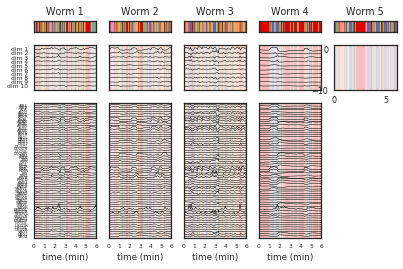

In [352]:
def make_figure_6(overlay=True, tmin=0, tmax=6, smpl=0):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, W, height_ratios=[1, 4, 12])

    for w in range(W):
        # Plot discrete latent states
        ax = fig.add_subplot(gs[0, w])
        ax.imshow(zsmpls[w + smpl*W][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto")
        ax.set_xticks([])
        ax.set_yticks([])
        # if w == 0:
        #    ax.set_ylabel("Discrete States")
        ax.set_title("Worm {}".format(w+1))

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, w])
        
        if overlay:
            ax.imshow(zsmpls[w + smpl*W][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -D, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (xsmpls[w + smpl*W][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
            # ax.set_ylabel("Continuous States")
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot neural activity
        ax = fig.add_subplot(gs[2, w])
        
        if overlay:
            ax.imshow(zsmpls[w + smpl*W][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N, 1), 
                      alpha=.25)
            
        ax.plot(tslc, ysmpls[w + smpl*W][slc] - np.arange(N), '-k', lw=0.5)
        if w == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names, fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
        ax.set_ylim(-N,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

#     figname = "figure6" if overlay else "figure6_white"
#     plt.savefig(os.path.join(results_dir, figname + ".pdf"))
#     plt.savefig(os.path.join(results_dir, figname + ".png"))

make_figure_6(overlay=True, smpl=7)
# make_figure_6(overlay=False)

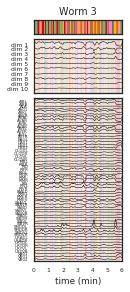

In [358]:
def make_figure_6_panel(w, overlay=True, tmin=0, tmax=6, smpl=0):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(1.75, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, 1, height_ratios=[1, 4, 12])

    # Plot discrete latent states
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(z_infs[w][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto")
    ax.set_xticks([])
    ax.set_yticks([])
    # if w == 0:
    #    ax.set_ylabel("Discrete States")
    ax.set_title("Worm {}".format(w+1))

    # Plot continuous latent states
    ax = fig.add_subplot(gs[1, 0])

    if overlay:
        ax.imshow(zsmpls[w + smpl*W][slc][None, :], 
                  vmin=0, vmax=len(zplt.default_colors)-1, 
                  cmap=zplt.default_cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -D, 1), 
                  alpha=.25)

    ax.plot(tslc, (xsmpls[w + smpl*W][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
    ax.set_yticks(np.arange(0, -D, -1))
    ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
    ax.set_ylim(-D,1)

    ax.set_xlim(tmin, tmax)
    ax.set_xticks([])

    # Plot neural activity
    ax = fig.add_subplot(gs[2, 0])

    if overlay:
        ax.imshow(zsmpls[w + smpl*W][slc][None, :], 
                  vmin=0, vmax=len(zplt.default_colors)-1, 
                  cmap=zplt.default_cmap, 
                  aspect="auto", 
                  extent=(tmin, tmax, -N, 1), 
                  alpha=.25)

    ax.plot(tslc, ysmpls[w + smpl*W][slc] - np.arange(N), '-k', lw=0.5)
    ax.set_yticks(-np.arange(N))
    ax.set_yticklabels(neuron_names, fontsize=4)
    ax.set_ylim(-N,1)

    ax.set_xlim(tmin, tmax)
    ax.set_xticks(np.arange(tmin, tmax+1))
    ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
    ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

    figname = "figure6_w{}".format(w) if overlay else "figure6_w{}_white".format(w)
    plt.savefig(os.path.join(results_dir, figname + ".pdf"))
    plt.savefig(os.path.join(results_dir, figname + ".png"))

make_figure_6_panel(2, overlay=True)
# make_figure_1_panel(4, overlay=False)